In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, kendalltau
from cliffs_delta import cliffs_delta

sns.set_theme(style="whitegrid", context='talk', palette='Greys')

## Correlation analysis

In [10]:
data = pd.read_csv("data/bias_symptoms_raw.csv", index_col=[0, 1])

In [15]:
data

,,correlation_true,mutual_info,unpriv_prob_pos,priv_prob_pos,unbalance,unpriv_prob_neg,priv_prob_neg,pos_prob,neg_prob,kurtosis_var,skew_var,statistical_parity,equal_opportunity,average_odds
variable,data,,,,,,,,,,,,,,
race,adult,0.084531,0.004036,0.129252,0.252500,0.536785,0.870748,0.747500,-0.123248,0.123248,5.639858,-2.763370,-0.167058,-0.055782,-0.221519
sex,adult,0.230065,0.029482,0.101744,0.310378,0.422546,0.898256,0.689622,-0.208634,0.208634,-1.501940,-0.706421,-0.157207,-0.127140,-0.058324
10th,adult,-0.079627,0.004225,0.246914,0.051546,1.025437,0.753086,0.948454,0.195367,-0.195367,26.974784,5.381203,0.191191,0.118290,0.309504
11th,adult,-0.091252,0.005677,0.248489,0.043103,1.031979,0.751511,0.956897,0.205385,-0.205385,21.748435,4.871794,0.192411,0.127817,0.309825
12th,adult,-0.051403,0.001712,0.243518,0.063830,1.011336,0.756482,0.936170,0.179688,-0.179688,60.945596,7.931343,0.144844,0.060667,0.284822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
type,wine,0.085865,0.005864,0.384615,0.476510,0.852241,0.615385,0.523490,-0.091895,0.091895,-0.975126,-1.013928,-0.159525,0.014760,-0.149652
alcohol,wine,0.363793,0.081020,0.404580,0.497175,0.883764,0.595420,0.502825,-0.092595,0.092595,-1.914522,-0.302827,-0.640531,-0.015267,-0.626511
type,wine,0.142046,0.013685,0.416667,0.469008,0.910165,0.583333,0.530992,-0.052342,0.052342,-0.051297,-1.396023,-0.235537,-0.039945,-0.233977


In [11]:
data.shape

(5930, 14)

In [12]:
sp = data.pop('statistical_parity')
eo = data.pop('equal_opportunity')
ao = data.pop('average_odds')

data.insert(len(data.columns), 'statistical_parity', sp)
data.insert(len(data.columns), 'equal_opportunity', eo)
data.insert(len(data.columns), 'average_odds', ao)

In [13]:
kendall = data.corr("kendall").round(3)
for col in kendall.columns:
    for col2 in kendall.columns:
        pval = kendalltau(data[col], data[col2])[1]
        if np.abs(kendall.loc[col, col2]) > 0.25:
            kendall.loc[col, col2] = r"\textbf{" + str(kendall.loc[col, col2]) + "}"
        if pval > 0.05:
            kendall.loc[col, col2] = f"{kendall.loc[col, col2]}*"

C:\Users\giord\AppData\Local\Temp\ipykernel_26164\2886176029.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{1.0}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  kendall.loc[col, col2] = r"\textbf{" + str(kendall.loc[col, col2]) + "}"
C:\Users\giord\AppData\Local\Temp\ipykernel_26164\2886176029.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.015*' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  kendall.loc[col, col2] = f"{kendall.loc[col, col2]}*"
C:\Users\giord\AppData\Local\Temp\ipykernel_26164\2886176029.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.002*' has dtype incompatible with float64, please explicitly cast to a compati

In [14]:
kendall.to_latex('full_corr.tex', float_format="%.3f", escape=False)

## Distribution of the data

In [62]:
def plot_differences(symps, symp, symp_name):
    corr_high_sp = symps[symps["statistical_parity"] == 1][symp].values
    corr_low_sp = symps[symps["statistical_parity"] == 0][symp].values
    corr_high_eo = symps[symps["equal_opportunity"] == 1][symp].values
    corr_low_eo = symps[symps["equal_opportunity"] == 0][symp].values
    corr_high_ao = symps[symps["average_odds"] == 1][symp].values
    corr_low_ao = symps[symps["average_odds"] == 0][symp].values
    df = pd.DataFrame(
        {
            symp_name: [
                corr_high_sp,
                corr_low_sp,
                corr_high_eo,
                corr_low_eo,
                corr_high_ao,
                corr_low_ao,
            ],
            "Metric": [
                "Statistical Parity",
                "Statistical Parity",
                "Equal Opportunity",
                "Equal Opportunity",
                "Average Odds",
                "Average Odds",
            ],
            "Bias": ["High", "Low", "High", "Low", "High", "Low"],
        }
    )
    df = df.explode(symp_name)
    g = sns.FacetGrid(df, col="Metric", height=4, aspect=1)
    g.map(
        sns.barplot,
        "Bias",
        symp_name,
        "Bias",
        order=["Low", "High"],
        hue_order=["Low", "High"],
        palette=sns.color_palette()[1:4:2],
    )
    g.set_titles("{col_name}")
    g.add_legend()
    # g.facet_axis(0,0).set_xlabel("T test pvalue: "+str(ttest_ind(corr_high_sp, corr_low_sp, equal_var=False)[1]))
    # g.facet_axis(0,1).set_xlabel("T test pvalue: "+str(ttest_ind(corr_high_eo, corr_low_eo, equal_var=False)[1]))
    # g.facet_axis(0,2).set_xlabel("T test pvalue: "+str(ttest_ind(corr_high_ao, corr_low_ao, equal_var=False)[1]))
    g.set_axis_labels("", symp_name)
    # plt.savefig(f"figs/{symp_name}.pdf", bbox_inches="tight")
    # plt.show()
    print(ttest_ind(corr_high_sp, corr_low_sp, equal_var=False))
    print(ttest_ind(corr_high_eo, corr_low_eo, equal_var=False))
    print(ttest_ind(corr_high_ao, corr_low_ao, equal_var=False))
    print(cliffs_delta(corr_high_sp, corr_low_sp))
    print(cliffs_delta(corr_high_eo, corr_low_eo))
    print(cliffs_delta(corr_high_ao, corr_low_ao))
    return g

### Analysis of Mutual Information

TtestResult(statistic=12.497085116188682, pvalue=2.45608274917653e-35, df=5246.8528586964485)
TtestResult(statistic=4.531328768164293, pvalue=5.982100050014694e-06, df=5651.671272645009)
TtestResult(statistic=8.769858885420069, pvalue=2.3569751280756018e-18, df=5450.057812591448)
(0.25087381402824993, 'small')
(0.14127782560948976, 'negligible')
(0.16208580486369564, 'small')


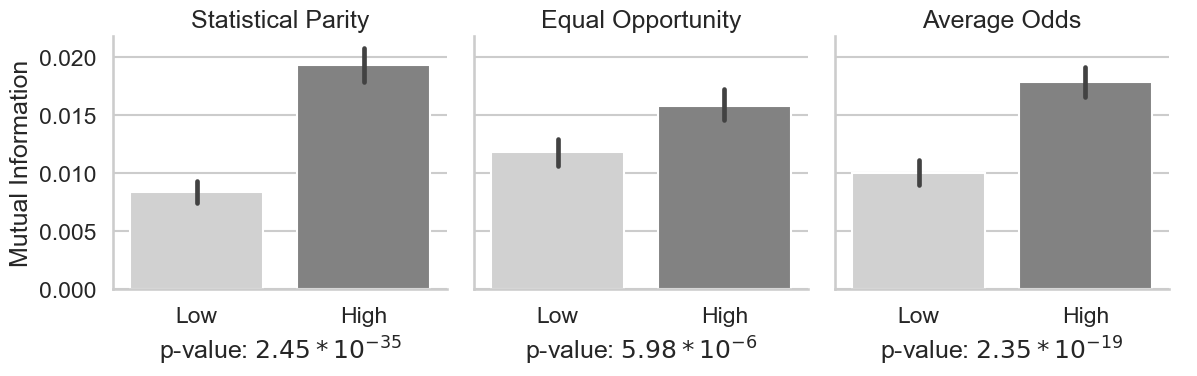

In [66]:
g = plot_differences(data, "mutual_info", "Mutual Information")
g.facet_axis(0, 0).set_xlabel(
    "p-value: $2.45*10^{-35}$", labelpad=5, fontdict={"fontsize": 18}
)
g.facet_axis(0, 1).set_xlabel(
    "p-value: $5.98*10^{-6}$", labelpad=5, fontdict={"fontsize": 18}
)
g.facet_axis(0, 2).set_xlabel(
    "p-value: $2.35*10^{-19}$", labelpad=5, fontdict={"fontsize": 18}
)
plt.savefig("figs/Mutual Information.pdf", bbox_inches="tight")
plt.show()

## Kendall's Tau

TtestResult(statistic=4.908530046429225, pvalue=9.458185885482086e-07, df=5170.073193669627)
TtestResult(statistic=0.9311691794241514, pvalue=0.35180448476204074, df=5849.734125429803)
TtestResult(statistic=2.2497685037907496, pvalue=0.024504302429927863, df=5326.820882148036)
(0.07361203965804185, 'negligible')
(-0.01988811822677609, 'negligible')
(0.02934073673405567, 'negligible')


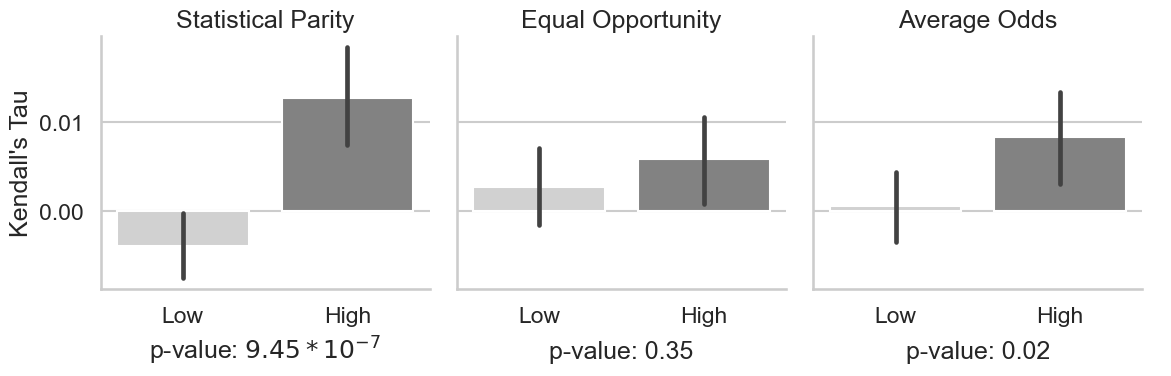

In [65]:
g = plot_differences(data, "correlation_true", "Kendall's Tau")

g.facet_axis(0,0).set_xlabel("p-value: $9.45*10^{-7}$", labelpad=5, fontdict={'fontsize': 18})
g.facet_axis(0, 1).set_xlabel(
    "p-value: 0.35", labelpad=10, fontdict={"fontsize": 18}
)
g.facet_axis(0, 2).set_xlabel(
    "p-value: 0.02", labelpad=10, fontdict={"fontsize": 18}
)
plt.savefig("figs/Kendall's Tau.pdf", bbox_inches="tight")
plt.show()

## Metrics Distribution

In [40]:
distr = pd.DataFrame(
    [
        {
            "Statistical Parity": [
              data[data["statistical_parity"] == 0].shape[0]/data.shape[0],
              data[data["statistical_parity"] == 1].shape[0]/data.shape[0],
            ],
            "Equal Opportunity": [
              data[data["equal_opportunity"] == 0].shape[0]/data.shape[0],
              data[data["equal_opportunity"] == 1].shape[0]/data.shape[0],
            ],
            "Average Odds": [
              data[data["average_odds"] == 0].shape[0]/data.shape[0],
              data[data["average_odds"] == 1].shape[0]/data.shape[0],
            ],
            "Bias": ["Low", "High"]
        }
    ]
)

In [41]:
distr = distr.explode(['Statistical Parity', 'Equal Opportunity', 'Average Odds', 'Bias']).melt(id_vars='Bias', var_name='Metric', value_name='Percentage')

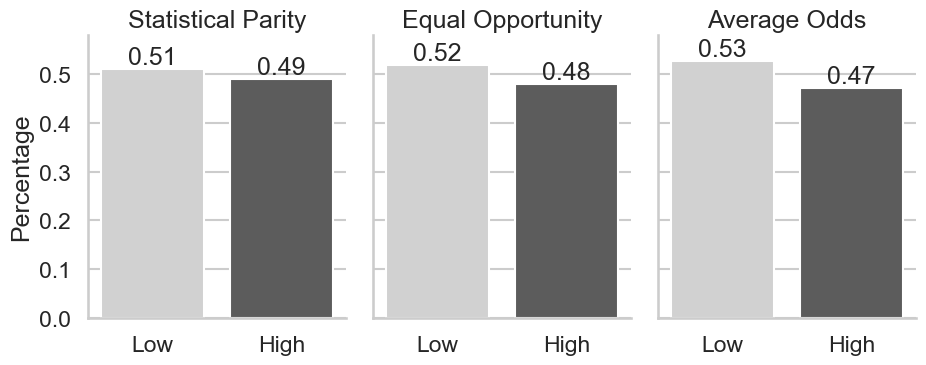

In [59]:
g = sns.catplot(
    data=distr,
    col="Metric",
    x="Bias",
    y="Percentage",
    kind="bar",
    hue="Bias",
    palette=sns.color_palette()[1:5:3],
    height=4,
    aspect=0.8,
)


for i in range(3):
    g.facet_axis(0, i).bar_label(g.facet_axis(0, i).containers[0], fmt="%.2f")
    g.facet_axis(0, i).bar_label(g.facet_axis(0, i).containers[1], fmt="%.2f")

g.set_titles("{col_name}")
# plt.subplots_adjust(top=1.3)
g.set_axis_labels("")
plt.ylim(0,0.58)
plt.tight_layout()
plt.savefig('metrics_distr.png', dpi=300, bbox_inches='tight')
plt.savefig("figs/metrics_distr.pdf", bbox_inches="tight")
plt.show()

## Distribution of SP, EO and AO

In [43]:
raw = pd.read_csv("data/bias_symptoms_raw.csv", index_col=[0, 1])
metrics = raw[['statistical_parity', 'equal_opportunity', 'average_odds']]
metrics = pd.melt(metrics, var_name='Metric', value_name='Value')
metrics['Metric'] = metrics['Metric'].map({'statistical_parity': 'Statistical Parity', 'equal_opportunity': 'Equal Opportunity', 'average_odds': 'Average Odds'})
metrics['Value'] = metrics['Value'].abs()

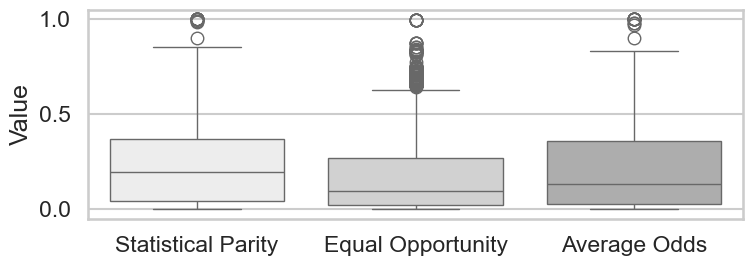

In [44]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.boxplot(data=metrics, x='Metric', y='Value', hue='Metric')
plt.xlabel('')
plt.tight_layout()
plt.savefig('figs/metrics_boxplot.pdf', bbox_inches='tight')
plt.show()